# Insurance claims prediction



In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from copy import deepcopy
import xgboost as xgb
import pickle
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import KFold, train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train)

            id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9    ...     \
0            1    A    B    A    B    A    A    A    A    B    ...      
1            2    A    B    A    A    A    A    A    A    B    ...      
2            5    A    B    A    A    B    A    A    A    B    ...      
3           10    B    B    A    B    A    A    A    A    B    ...      
4           11    A    B    A    B    A    A    A    A    B    ...      
5           13    A    B    A    A    A    A    A    A    B    ...      
6           14    A    A    A    A    B    A    A    A    A    ...      
7           20    A    B    A    B    A    A    A    A    B    ...      
8           23    A    B    B    B    B    A    A    A    B    ...      
9           24    A    B    A    A    B    B    A    A    B    ...      
10          25    A    B    A    A    A    A    A    A    B    ...      
11          33    A    B    A    A    B    A    A    A    B    ...      
12          34    B    A    A    A    B    A    A  

In [15]:
train.info()
#print(train.shape)
#In here, `float64(15), int64(1)` are our continuous features (the one with `int64` is probably `id`) while `object(116)` are categorical features. We may confirm this:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


188k训练实例，132列 数据量还可以。

In [16]:
print (list(train.columns))

['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', '

In [17]:
# There are 116 categorical features and 14 continuous features in the data
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [10]:
#There is no missing values in the data
pd.isnull(train).values.any()

False

## Continuous vs caterogical features

In [3]:
cat_features = list(train.select_dtypes(include=['object']).columns)
print ("Categorical: {} features".format(len(cat_features)))

Categorical: 116 features


In [4]:
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
print ("Continuous: {} features".format(len(cont_features)))

Continuous: 14 features


In [5]:
id_col = list(train.select_dtypes(include=['int64']).columns)
print ("A column of int64: {}".format(id_col))

A column of int64: ['id']


In [21]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    
uniq_values_in_categories = pd.DataFrame.from_items([('cat_name', cat_features), ('unique_values', cat_uniques)])

In [28]:
uniq_values_in_categories.head(20)

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2
5,cat6,2
6,cat7,2
7,cat8,2
8,cat9,2
9,cat10,2


Text(7,71,'Binary features')

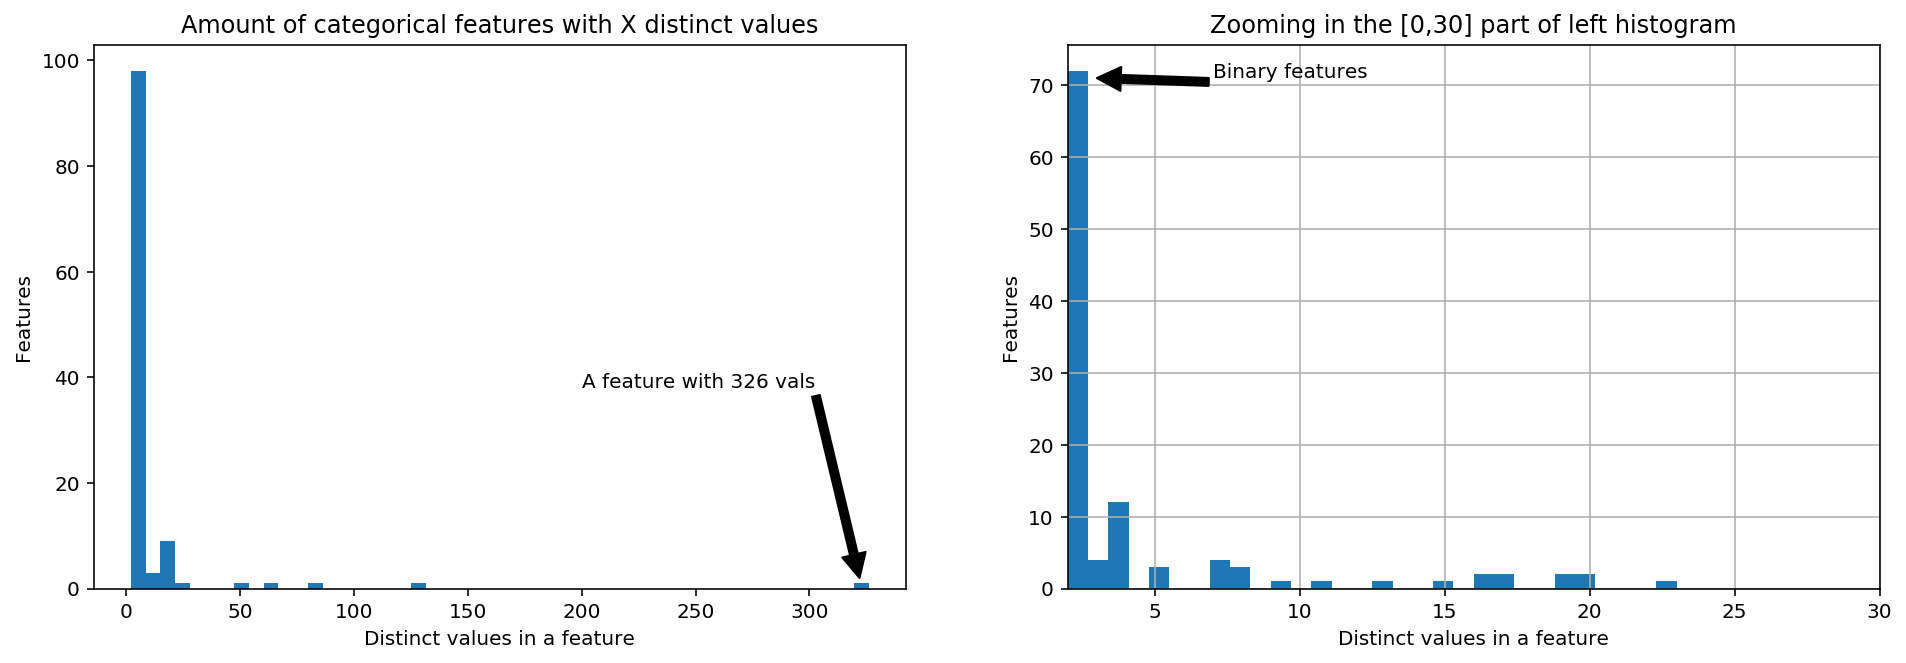

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(uniq_values_in_categories.unique_values, bins=50)
ax1.set_title('Amount of categorical features with X distinct values')
ax1.set_xlabel('Distinct values in a feature')
ax1.set_ylabel('Features')
ax1.annotate('A feature with 326 vals', xy=(322, 2), xytext=(200, 38), arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title('Zooming in the [0,30] part of left histogram')
ax2.set_xlabel('Distinct values in a feature')
ax2.set_ylabel('Features')
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values <= 30].unique_values, bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

most features are binary(72 out of 116)正如我们所看到的，大部分的分类特征（72/116）是二值的，绝大多数特征（88/116）有四个值，其中有一个具有326个值的特征（一天的数量？）。

## 赔偿值

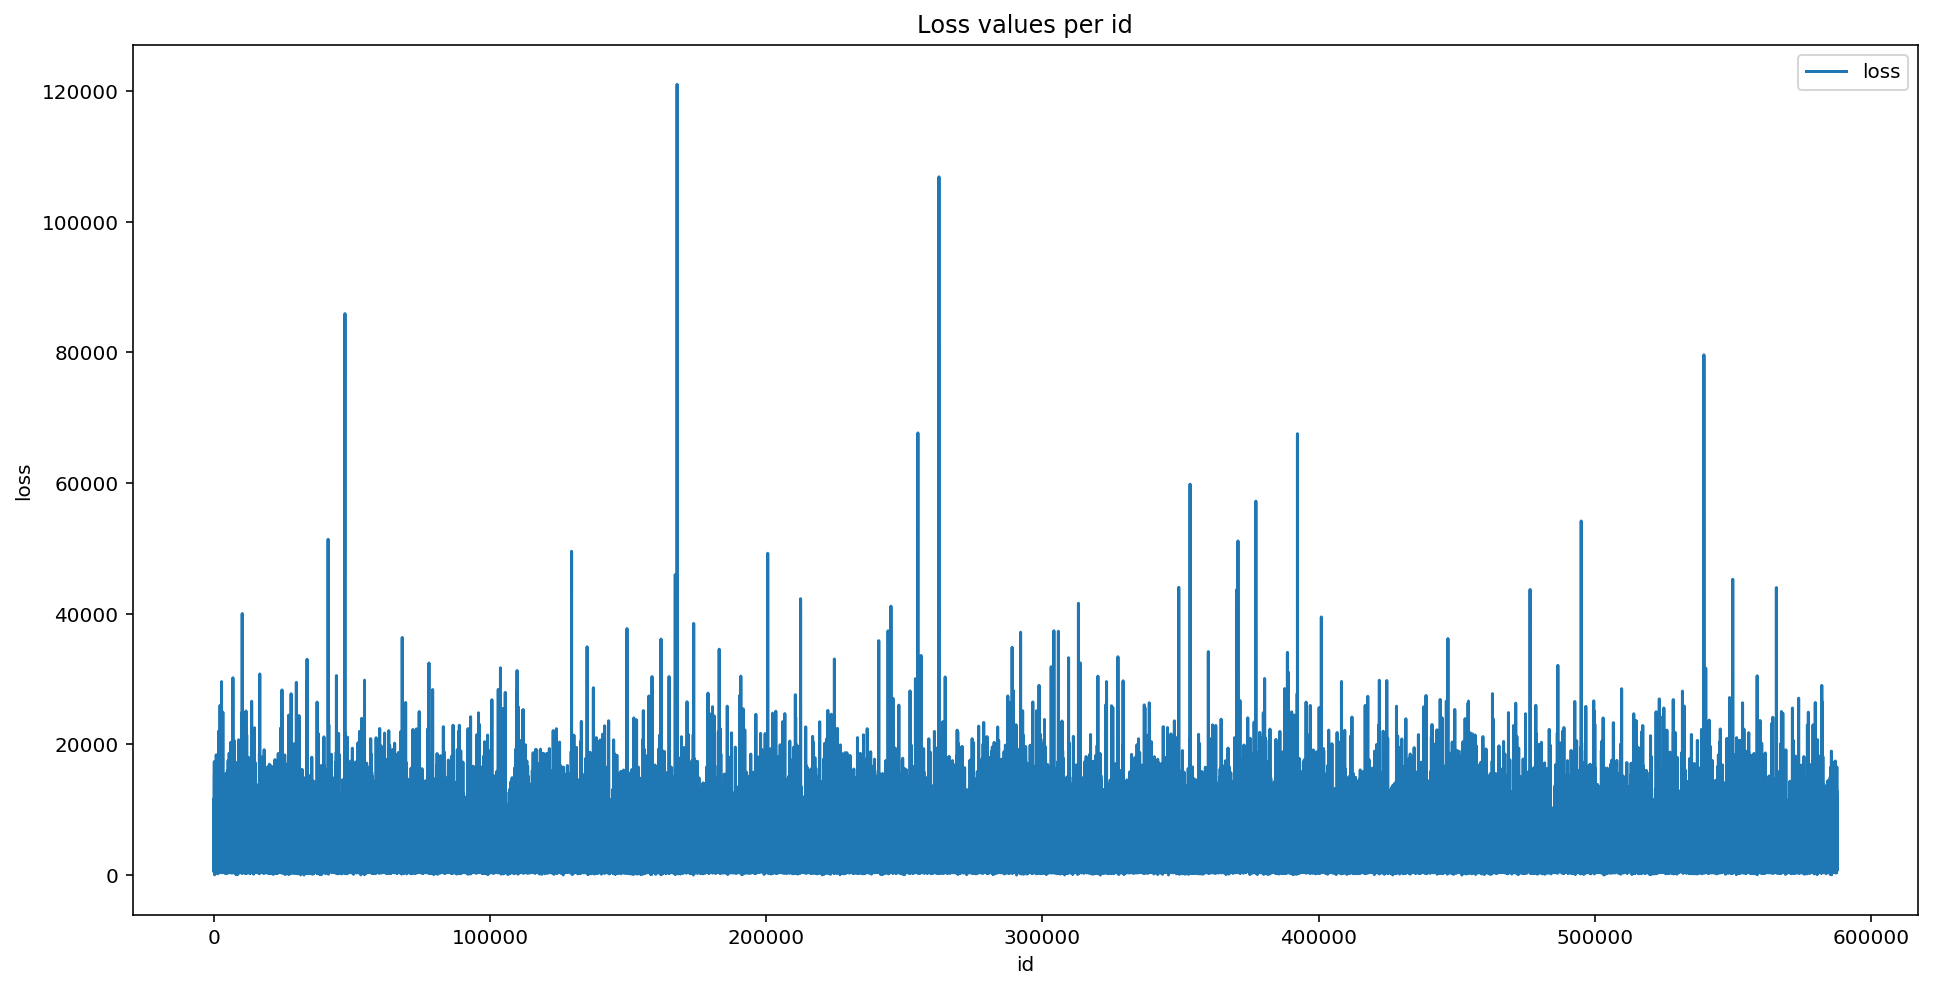

In [24]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

These high peaks correspond to severe accidents. Such a distribution leads to a very skewed structure thus impairs the performance of the regression.

基本上，偏度度量了实值随机变量的均值分布的不对称性。让我们计算损失的偏度：

In [25]:
stats.mstats.skew(train['loss']).data

array(3.79492815)

数据确实是倾斜的

 `np.log` treatment could improve the skewed structure 

In [7]:
train['log_loss'] = np.log(train['loss'])
stats.mstats.skew(train['log_loss']).data

array(0.0929738)

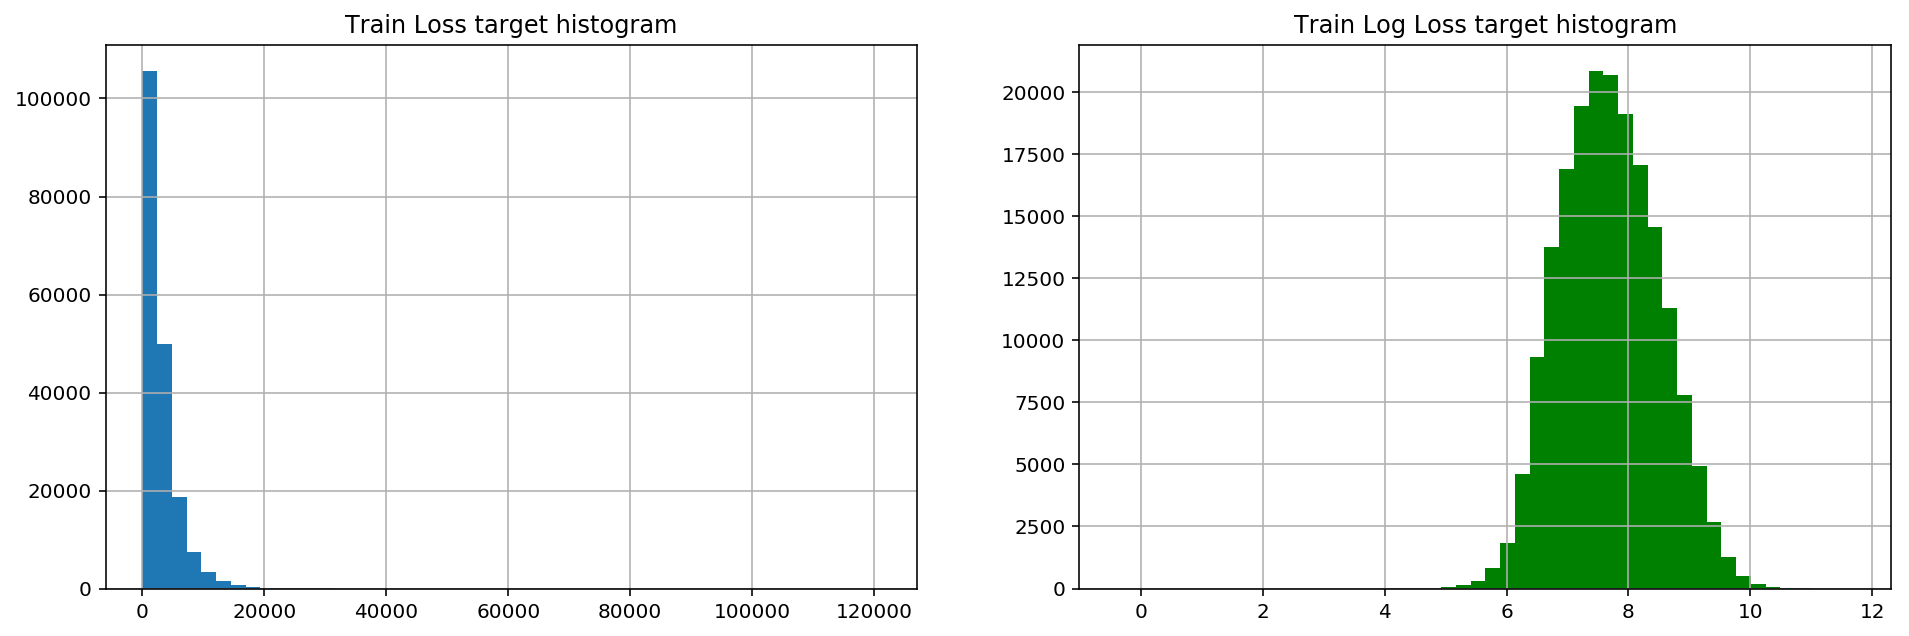

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

## 连续值特征

One thing we can do is to plot histogram of the numerical features and analyze their distributions:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113b49320>,
      dtype=object)

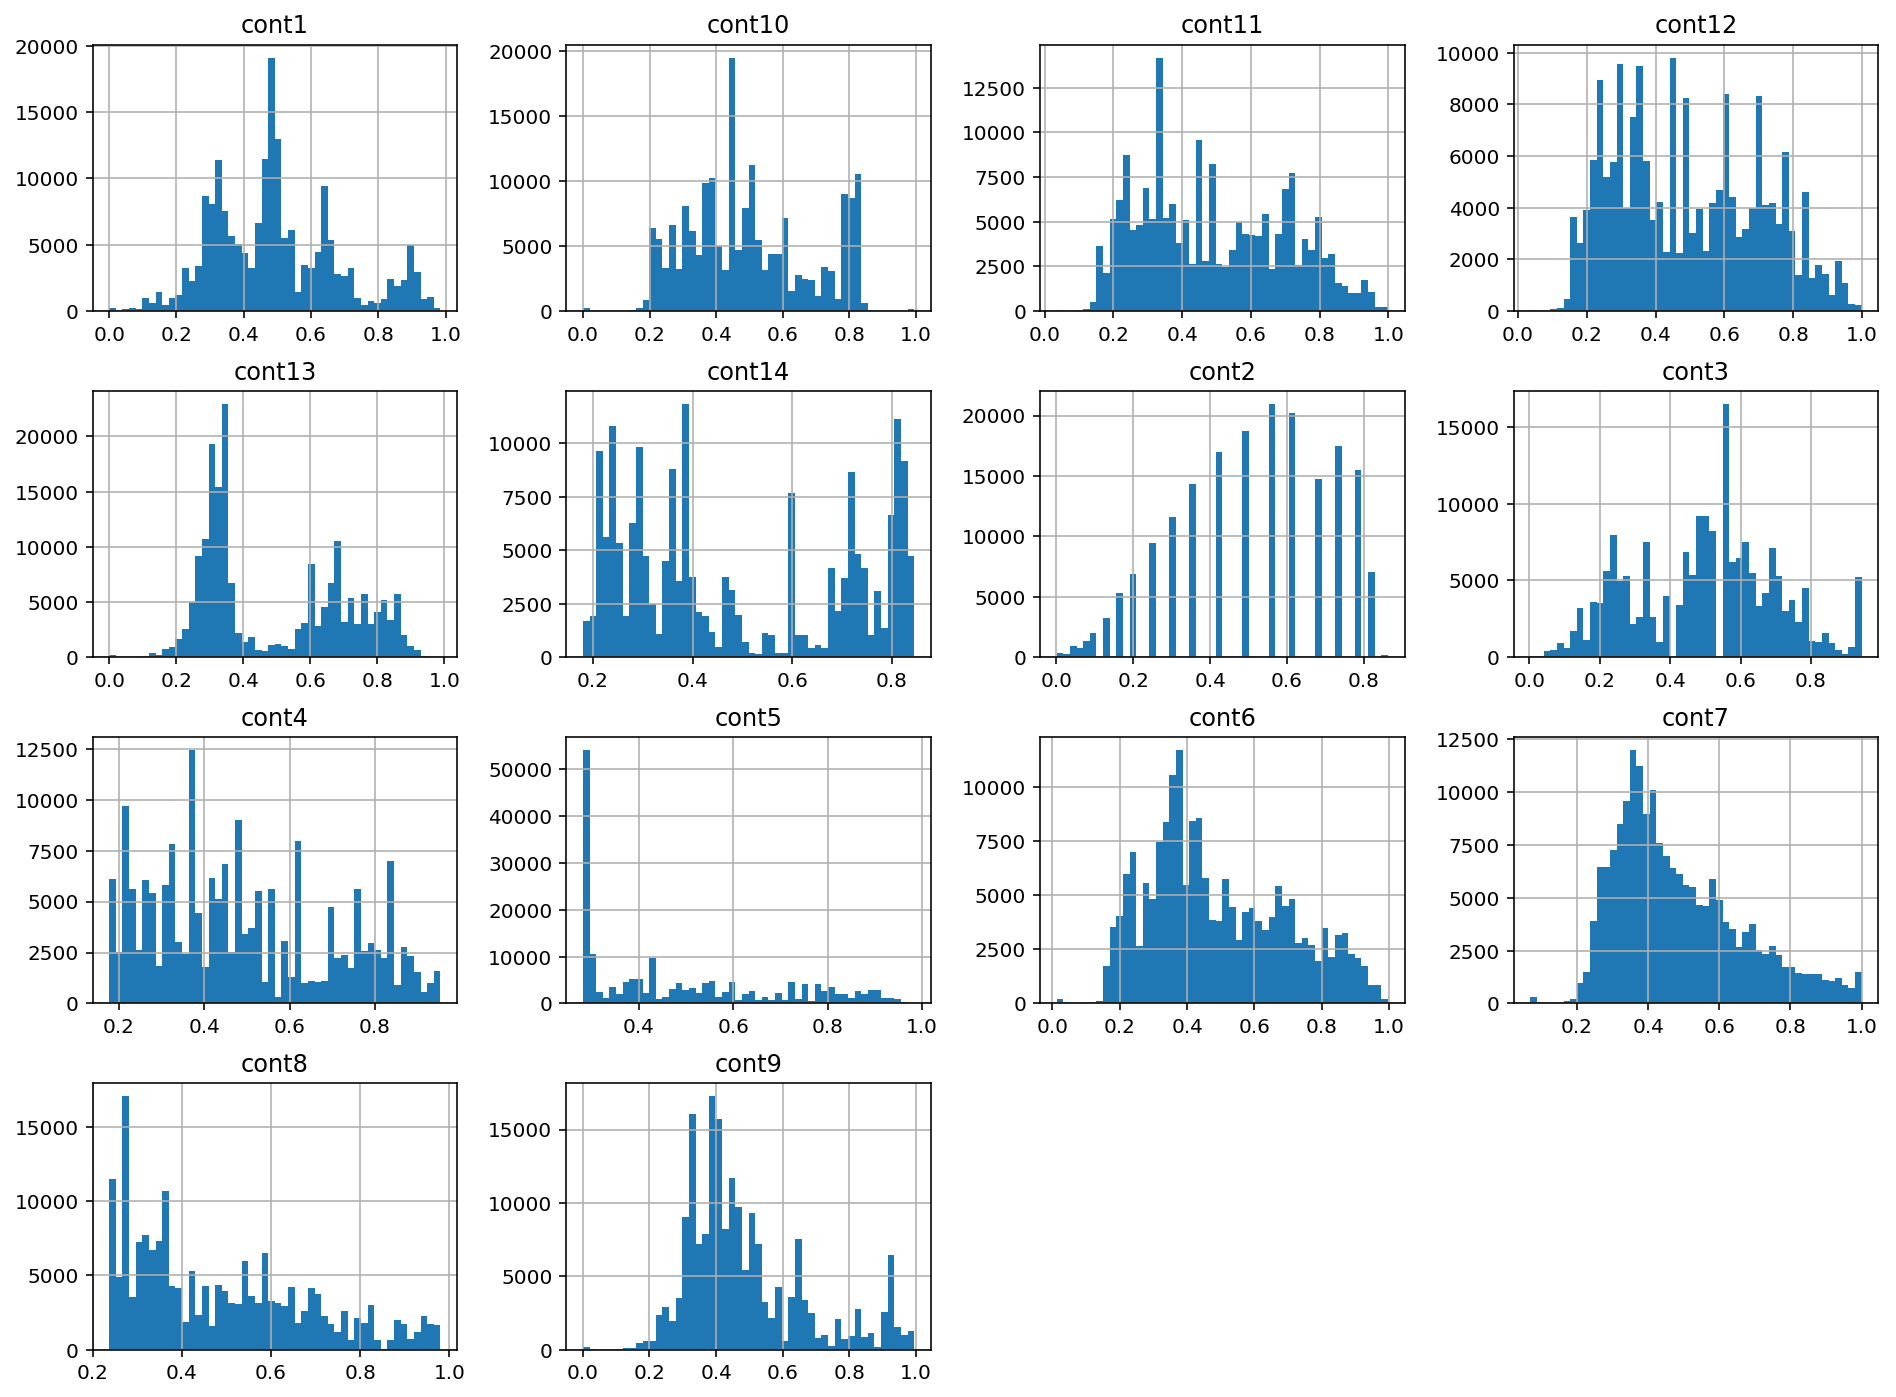

In [33]:
train[cont_features].hist(bins=50, figsize=(16,12))

### 特征之间的相关性

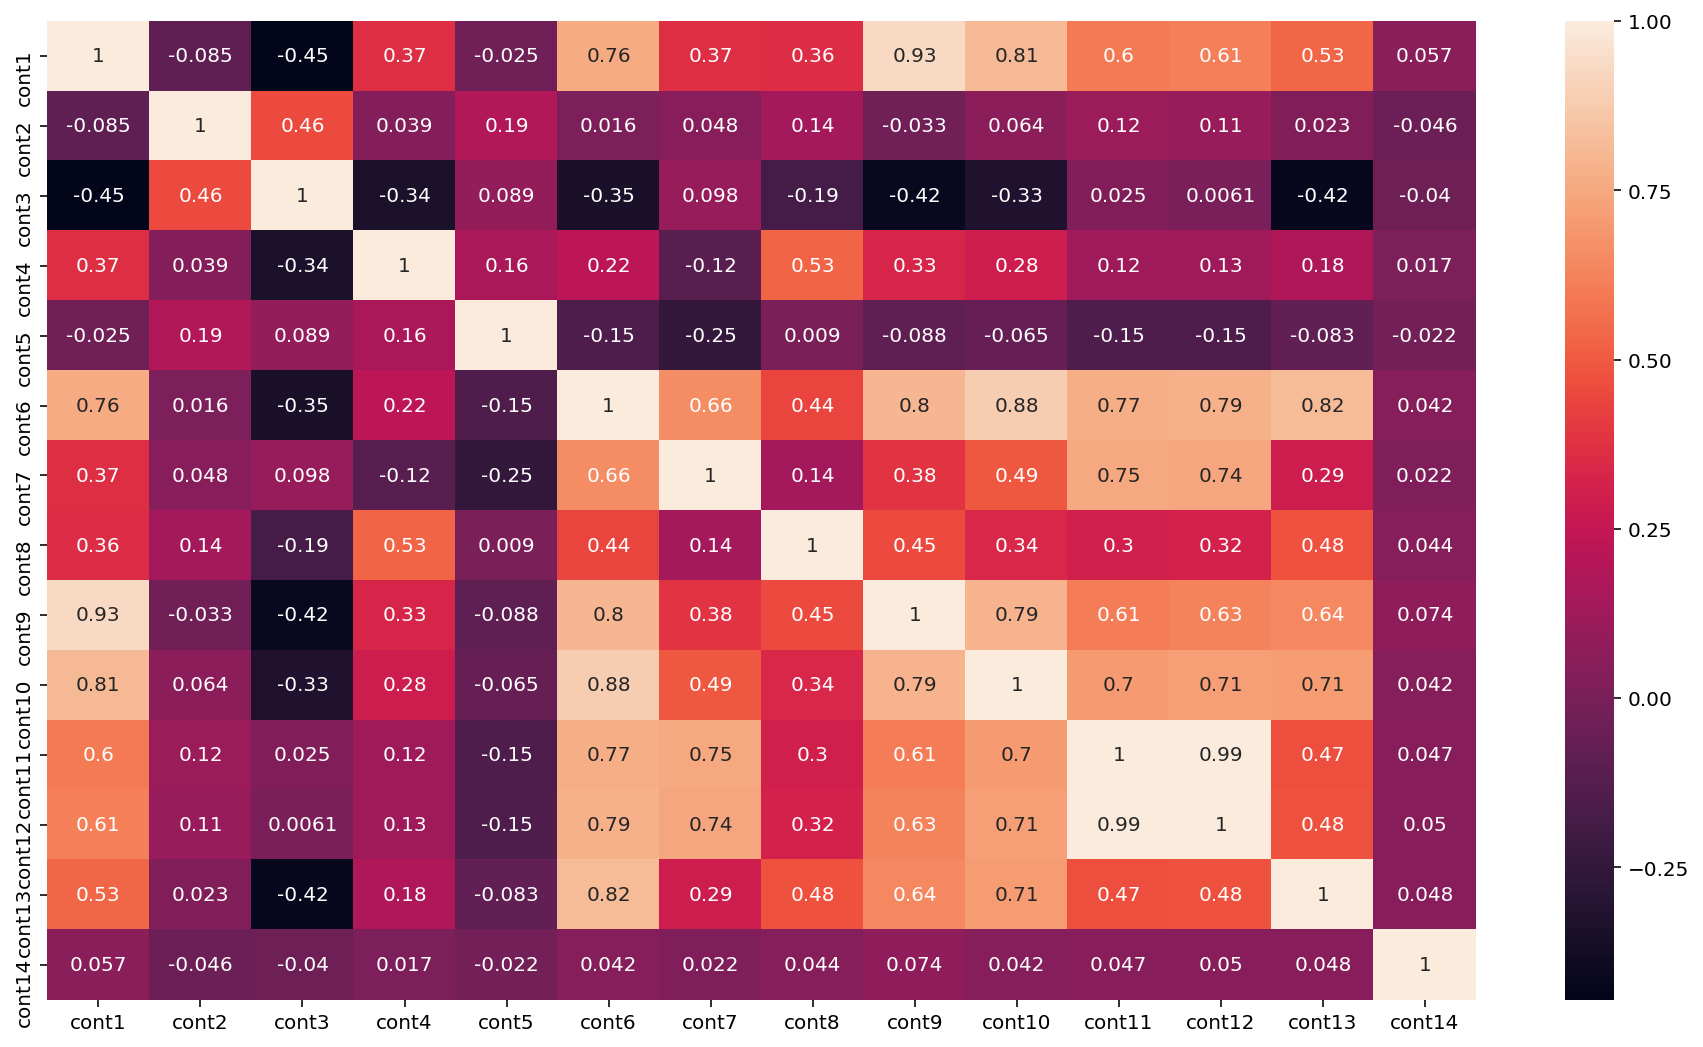

In [34]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True)

## Data prediction

In [8]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x.loc[:,cat_features[c]] = train_x.loc[:,cat_features[c]].astype('category').cat.codes
    
print ("Xtrain:", train_x.shape)
print ("ytrain:", train_y.shape)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Xtrain: (188318, 130)
ytrain: (188318,)


## Simple XGBoost Model

In [9]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

In [10]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth': 5,
    'min_child_weight': 3
}


In [11]:
%%time

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, 
                feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)

print ('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 1220.3452553333334
CPU times: user 1min 24s, sys: 1.41 s, total: 1min 25s
Wall time: 1min 26s


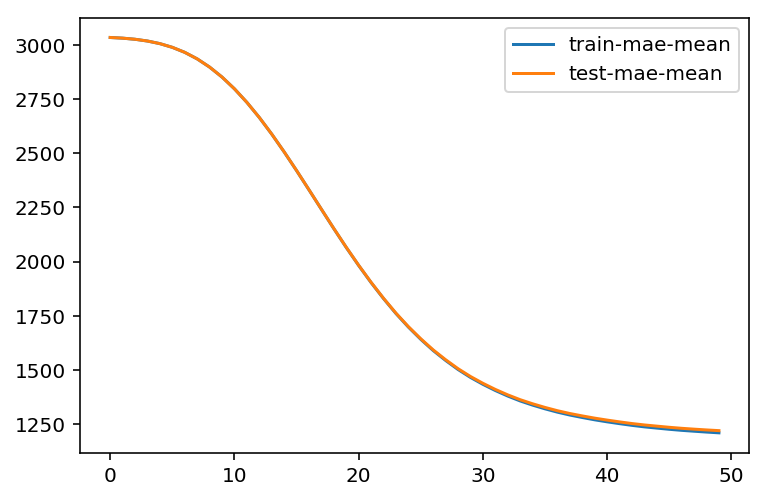

In [12]:
plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

In [13]:
%%time
#create a model with 100 trees

bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

1
111
CV score: 1171.5231526666666
CPU times: user 2min 14s, sys: 1.21 s, total: 2min 15s
Wall time: 2min 15s


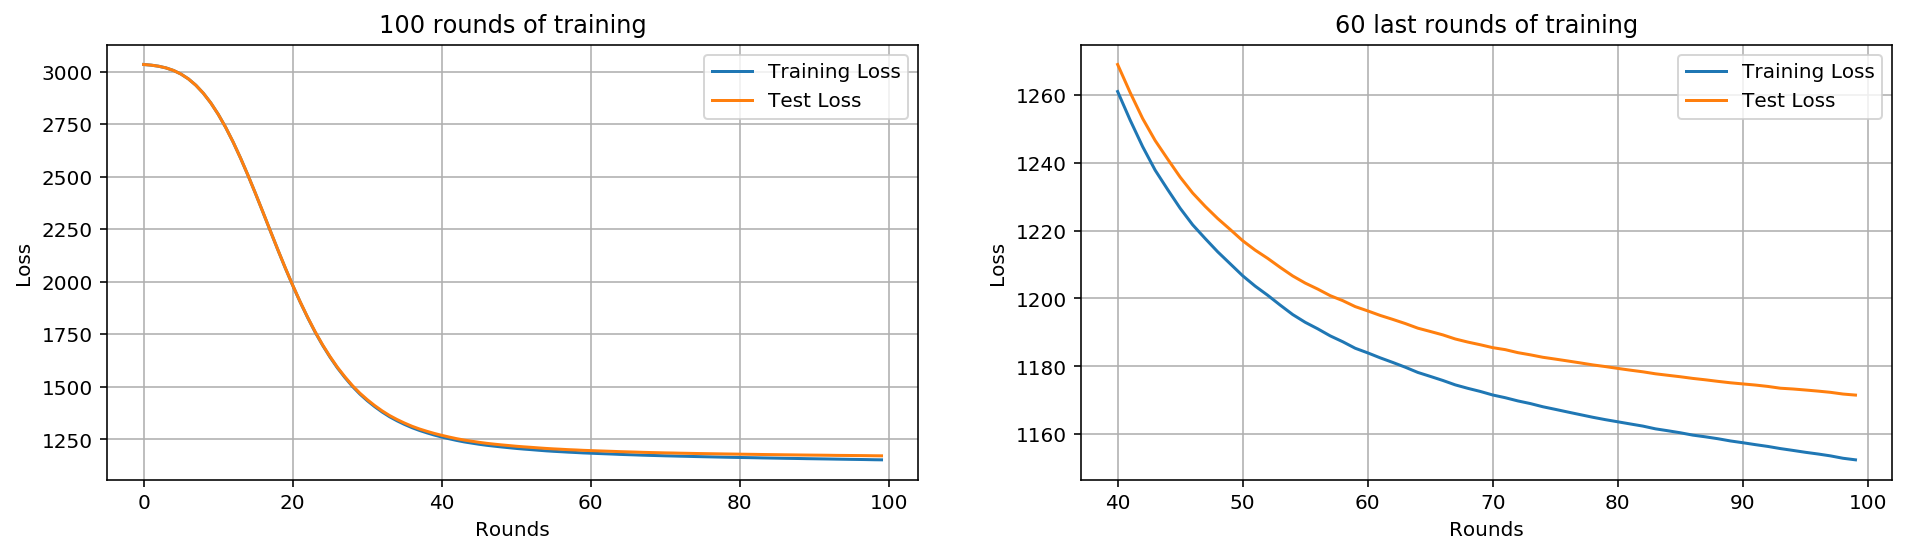

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

In [15]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [16]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

In [17]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)
bst.kfold(train_x, train_y, nfold=5)

test-mae-mean      1218.677563
test-mae-std          9.739220
test-rmse-mean        0.562966
test-rmse-std         0.002667
train-mae-mean     1210.106055
train-mae-std         1.498407
train-rmse-mean       0.559308
train-rmse-std        0.000582
Name: 49, dtype: float64

### step 1: improving the model by changing learning rate and the number of trees(as described above) 
### step 2: and max_depth+min_child_weight(below)

In [18]:
xgb_param_grid = {'max_depth': list(range(4,9)), 'min_child_weight': list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [19]:
%%time
 
grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 35min 4s, sys: 41.5 s, total: 35min 45s
Wall time: 40min 51s


In [20]:
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1242.48259, std: 6.85798, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -1242.31914, std: 6.71281, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -1242.52349, std: 6.76063, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -1218.32485, std: 6.53045, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -1217.75650, std: 6.23951, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -1217.54791, std: 6.26108, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -1204.49666, std: 6.37307, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -1203.75361, std: 5.72491, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -1203.45858, std: 5.78173, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -1195.56553, std: 5.13847, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -1194.77953, std: 5.75473, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -1193.95878, std: 5.40336, params: {'max_depth': 7, 'min_child_weigh

In [ ]:
#the best parameters given by grid_search are:{'max_depth': 8, 'min_child_weight': 6},-1187.9597499123447) set to
#negative values because we want to find the largest value

In [21]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [22]:
_,scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


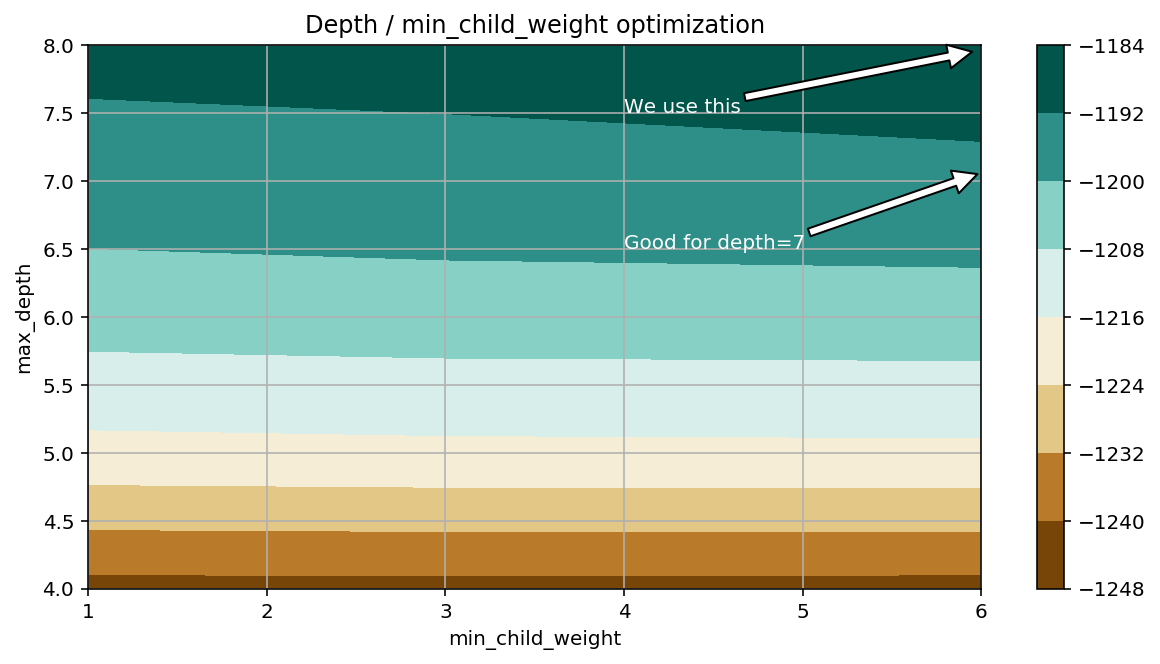

In [23]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

## step 3: change Gamma parameter

In [24]:
%%time

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 15min 54s, sys: 15.8 s, total: 16min 10s
Wall time: 16min 15s


In [25]:
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1187.22931, std: 5.87782, params: {'gamma': 0.0},
  mean: -1187.47617, std: 5.31065, params: {'gamma': 0.1},
  mean: -1187.04886, std: 5.44231, params: {'gamma': 0.2},
  mean: -1187.73013, std: 6.08707, params: {'gamma': 0.30000000000000004},
  mean: -1187.17491, std: 5.38703, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 -1187.048856756302)

### Step 4: optimize sampling mthod: subsample and colsample_bytree

In [26]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

CPU times: user 37min 13s, sys: 33.6 s, total: 37min 46s
Wall time: 38min 8s


In [29]:
grid.grid_scores_, grid.best_params_, grid.best_score_

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1184.93997, std: 5.80782, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -1183.50834, std: 5.79583, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -1182.42822, std: 5.98683, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -1184.12260, std: 6.18624, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.6000000000000001},
  mean: -1182.78645, std: 5.72150, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.7000000000000001},
  mean: -1182.81031, std: 5.99611, params: {'colsample_bytree': 0.7000000000000001, 'subsample': 0.8},
  mean: -1184.31482, std: 6.50890, params: {'colsample_bytree': 0.8, 'subsample': 0.6000000000000001},
  mean: -1183.87145, std: 5.92689, params: {'colsample_bytree': 0.8, 'subsample': 0.7000000000000001},
  mean: -1182.76135, std: 7.43336, params: {'colsample_bytree': 0.8, 'subsample': 0.8}],
 {'colsample_bytree': 0.600

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


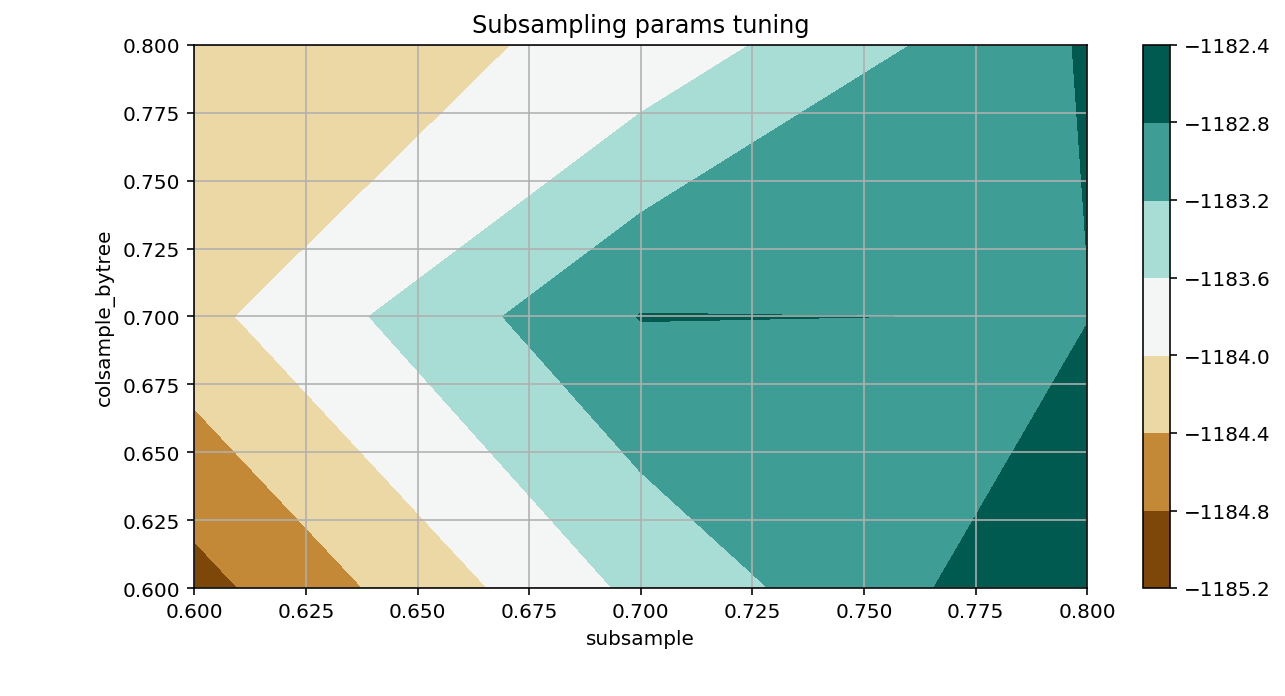

In [28]:
_, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(3,3)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

{'colsample_bytree': 0.6, 'subsample': 0.8},-1182.4282)

### Step 5: reduce learning rate and increase the number of trees

First, we plot different learning rates for a simpler model (50 trees):

In [31]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.8),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 29min 33s, sys: 24.1 s, total: 29min 57s
Wall time: 41min 48s


In [36]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1205.49979, std: 6.59794, params: {'eta': 0.5},
  mean: -1185.78917, std: 6.79624, params: {'eta': 0.4},
  mean: -1168.97970, std: 6.04281, params: {'eta': 0.3},
  mean: -1160.09656, std: 5.75732, params: {'eta': 0.2},
  mean: -1182.96912, std: 5.57641, params: {'eta': 0.1},
  mean: -1265.64537, std: 6.75432, params: {'eta': 0.075},
  mean: -1709.14503, std: 8.26989, params: {'eta': 0.05},
  mean: -2104.43714, std: 7.89586, params: {'eta': 0.04},
  mean: -2545.84835, std: 7.66881, params: {'eta': 0.03}],
 {'eta': 0.2},
 -1160.096564363316)

In [58]:
eta, y = convert_grid_scores(grid.grid_scores_)

print(list(eta),y)

dict_values([0.5])
dict_values([0.4])
dict_values([0.3])
dict_values([0.2])
dict_values([0.1])
dict_values([0.075])
dict_values([0.05])
dict_values([0.04])
dict_values([0.03])
<class 'dict_values'> [dict_values([0.5]), dict_values([0.4]), dict_values([0.3]), dict_values([0.2]), dict_values([0.1]), dict_values([0.075]), dict_values([0.05]), dict_values([0.04]), dict_values([0.03])] [-1205.4997945261664 -1185.7891673272472 -1168.9797022793637
 -1160.096564363316 -1182.9691239291471 -1265.6453699749334
 -1709.1450324614673 -2104.4371442015336 -2545.8483491277684]


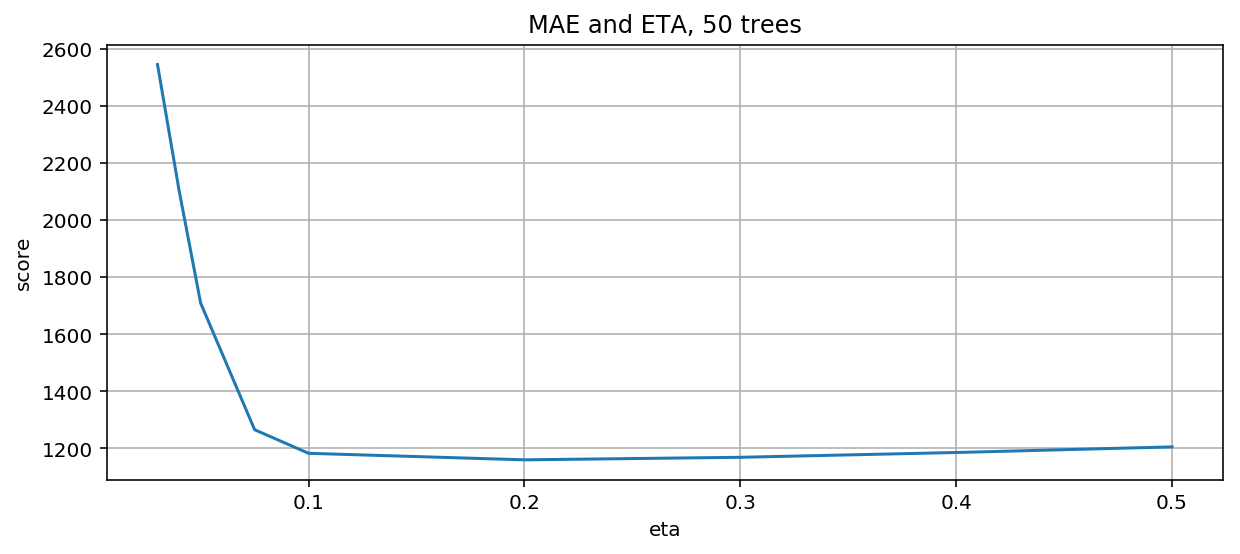

In [71]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(xgb_param_grid["eta"], -y)
plt.grid(True)
plt.show()

{'eta': 0.2}, -1160.9736284869114 is the best result till now

In [77]:
#Now we increase the number of trees to 100
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.8),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

GridSearchCV(cv=5, error_score='raise',
       estimator=<__main__.XGBoostRegressor object at 0x10f546908>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mae_score, greater_is_better=False), verbose=0)

In [85]:
grid.grid_scores_, grid.best_params_, grid.best_score_#,grid.cv_results_,

([mean: -1227.41285, std: 6.15787, params: {'eta': 0.5},
  mean: -1200.80976, std: 7.27064, params: {'eta': 0.4},
  mean: -1174.45350, std: 5.48956, params: {'eta': 0.3},
  mean: -1158.05381, std: 6.20274, params: {'eta': 0.2},
  mean: -1151.23387, std: 6.22291, params: {'eta': 0.1},
  mean: -1155.89941, std: 5.43653, params: {'eta': 0.075},
  mean: -1184.66446, std: 6.28735, params: {'eta': 0.05},
  mean: -1243.49863, std: 7.58203, params: {'eta': 0.04},
  mean: -1466.50298, std: 8.21300, params: {'eta': 0.03}],
 {'eta': 0.1},
 -1151.2338733371878)

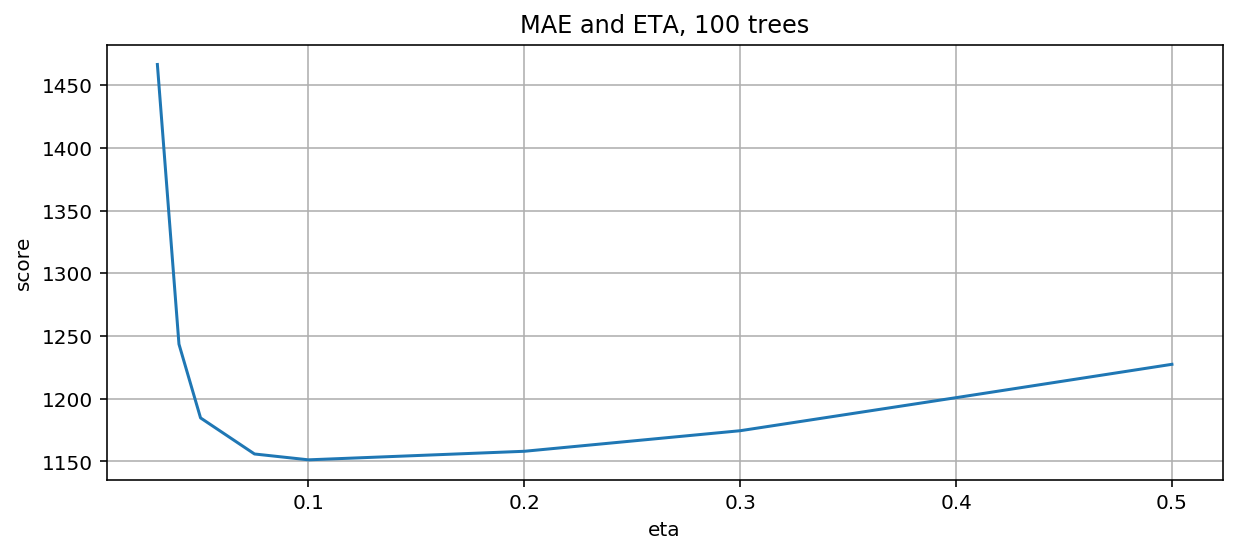

In [88]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(xgb_param_grid["eta"], -y)
plt.grid(True)
plt.show()

In [90]:
%%time
#Further increse the nuber of trees to 200
xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

CPU times: user 1h 17min 21s, sys: 16.6 s, total: 1h 17min 38s
Wall time: 1h 17min 41s


In [91]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -1145.43049, std: 6.03932, params: {'eta': 0.09},
  mean: -1145.70178, std: 4.81182, params: {'eta': 0.08},
  mean: -1146.03233, std: 5.62029, params: {'eta': 0.07},
  mean: -1146.17162, std: 6.62023, params: {'eta': 0.06},
  mean: -1147.70592, std: 6.32579, params: {'eta': 0.05},
  mean: -1152.28983, std: 6.01481, params: {'eta': 0.04}],
 {'eta': 0.09},
 -1145.4304861925305)

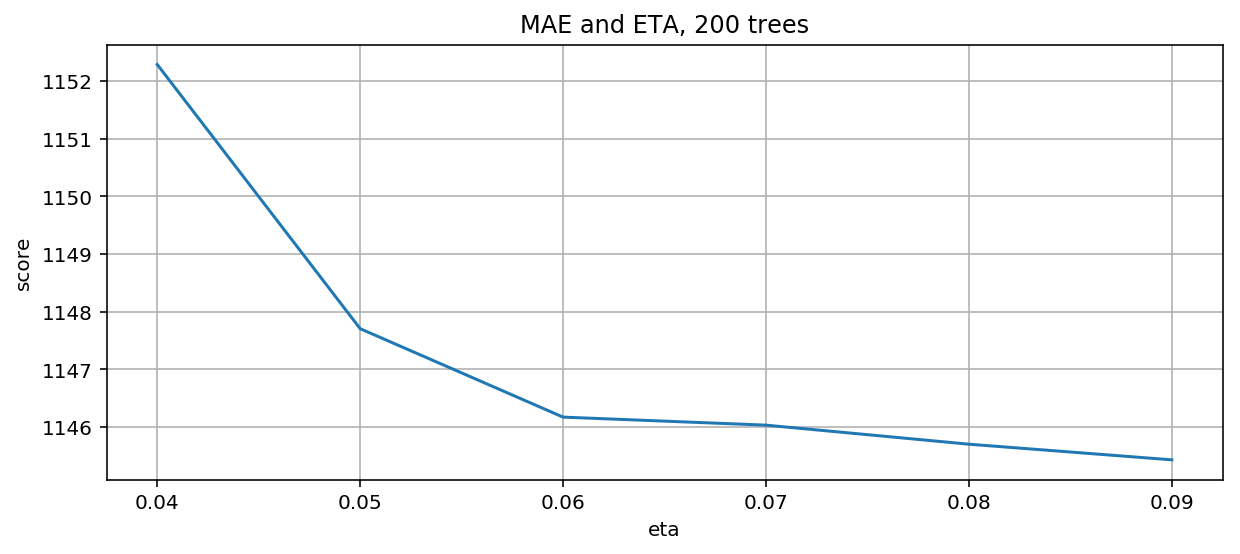

In [93]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(xgb_param_grid["eta"], -y)
plt.grid(True)
plt.show()

In [96]:
%%time

# Final XGBoost model

bst = XGBoostRegressor(num_boost_round=200, eta=0.09, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.8)
cv = bst.kfold(train_x, train_y, nfold=5)

CPU times: user 13min 38s, sys: 8.05 s, total: 13min 46s
Wall time: 14min 2s


In [97]:
cv

test-mae-mean      1145.516333
test-mae-std          8.019909
test-rmse-mean        0.537603
test-rmse-std         0.002294
train-mae-mean     1044.568335
train-mae-std         1.654189
train-rmse-mean       0.497439
train-rmse-std        0.000462
Name: 199, dtype: float64

We can see the best ETA parameter for 200 is 0.07. As expected, ETA and num_boost_round are not linearly dependent,but related somehow. After adjusting the parameters, MAE was optimized.
`XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.8, eta=0.07).